In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
 
class MultiAssetModel:
 
    def __init__(self, dt, T0, v0, T1, nassets, nk=1):
        self.dt = dt  # Time step.
        self.T0 = T0
        self.T1 = T1
        self.T = T1 - T0 # Total time.
        self.v0 = v0
        self.nt = int(self.T / dt)  # Number of time steps.
        self.dt = dt
        self.nassets = nassets
        self.nk = nk
        self.rng=np.random.RandomState(100)
 
    @property
    def tvalues(self):
        return np.linspace(self.T0, self.T1, num=self.nt)
 
    @property
    def tstep(self):
        return self.dt
   
    def __call__(self, mu, sigma):
        assert mu.ndim == 1
        assert self.nassets == mu.shape[0]
        assert sigma.ndim ==2
        assert self.nassets == sigma.shape[0]
        nbrownian = sigma.shape[1]
        eta_shape = (self.nt, self.nk, nbrownian)
        etas = self.rng.randn(*eta_shape)
        sqrtdt = np.sqrt(self.dt)
        x = np.zeros((self.nt, self.nk, self.nassets))
        x[0, ...]=self.v0
        for i in range(self.nt - 1):
            x[ i + 1, ...] = x[i, ...] + self.dt*mu*x[i, ...]  + \
            sqrtdt * x[i, ...]* np.dot(etas[i, ...], sigma.T)
        return x
 

In [2]:
mu = np.array([0.02, 0.025, 0.05, 0.06, 0.12, 0.15])  # Drift
sigma = np.array([[0.01, 0, 0, 0], [0.015, 0, 0, 0], [0, 0.04, -0.045, 0], [0, -0.045, 0.05, 0], [0.08, 0.2 , 0, 0.18], [0.081, 0, 0.1, 0.2]]) # Cov
print(mu.shape)
print(sigma.shape)

(6,)
(6, 4)


(10000, 1, 6)


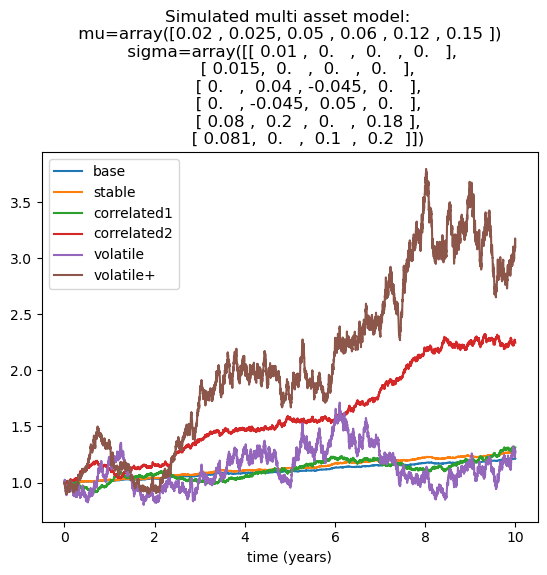

In [6]:
model = MultiAssetModel(dt=.001, T0=0, v0=1, T1=10, nassets = mu.shape[0])
assets = model(mu, sigma)
print(assets.shape)
time = model.tvalues
 
nassets = assets.shape[-1]
labels = ["base", "stable", "correlated1", "correlated2", "volatile", "volatile+"]
for iasset in range(nassets):
    plt.plot(time, assets[..., iasset], label =labels[iasset] )
plt.xlabel("time (years)")
plt.title(f"Simulated multi asset model: \n {mu=} \n {sigma=}")
plt.legend()
plt.show()
 


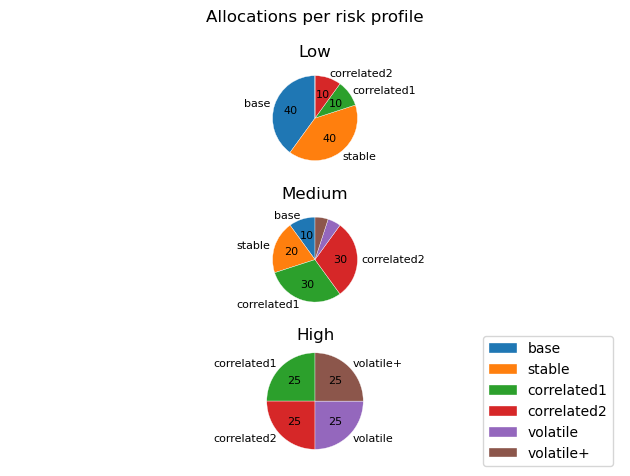

In [27]:

allocations = {
    "Low" : np.array([0.4, 0.4, 0.1, 0.1, 0 ,0]),
    "Medium" : np.array([0.1, 0.2, 0.3, 0.3, 0.05 ,0.05]),
    "High" : np.array([0.0, 0.0, 0.25, 0.25, 0.25 ,0.25]),
}

def autopct(pct):
    return ('%.0f' % pct) if pct > 5 else ''
nallocations = len(allocations)
fig, axs = plt.subplots(nallocations)
for i, (profile, allocation) in enumerate(allocations.items()):
    pcts = 100*allocation
    newlabels = [labels[i] if pct >5 else '' for i, pct in enumerate(pcts)]
    patches, texts, _ = axs[i].pie(pcts, labels=newlabels, 
               wedgeprops={'linewidth': 0.25, 'edgecolor': 'white'},
               textprops={'fontsize': 8},
               autopct=autopct, startangle=90)
    axs[i].set_title(f"{profile}")
plt.legend(patches, labels, loc="center right")
fig.suptitle("Allocations per risk profile")
plt.axis('equal')
plt.tight_layout()
plt.show()

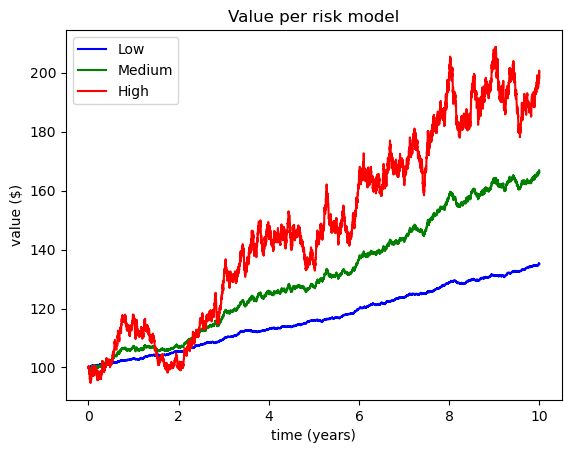

In [29]:
initial_investment = 100
colors = {"Low": "b", "Medium": "green", "High":"red"}
stockprices = np.squeeze(assets[:, 0, :])
for label, allocation in allocations.items():
   allocation = allocation/np.sum(allocation)
   investment = np.sum(initial_investment*allocation[np.newaxis, :]*stockprices, axis=-1)
   plt.plot(time, investment, color = colors[label], label=label)
plt.xlabel("time (years)")
plt.ylabel("value ($)")
plt.title(f"Value per risk model")
plt.legend()
plt.show()